In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
# Read data and merge
df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()
# Optional: Remove 4 applications with XNA CODE_GENDER (train set)
df = df[df['CODE_GENDER'] != 'XNA']
    
docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
#df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
#df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
#df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
#df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    # Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df, nan_as_category=False)
dropcolum=['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 
    'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
df= df.drop(dropcolum,axis=1)
    
del test_df
gc.collect()


# Preprocess bureau.csv and bureau_balance.csv
bureau = pd.read_csv('bureau.csv')
bb = pd.read_csv('bureau_balance.csv')
bb, bb_cat = one_hot_encoder(bb, nan_as_category=True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bb, bb_agg
gc.collect()
    
    # Bureau and bureau_balance numeric features
num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': [ 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
bureau_agg = bureau.groupby('SK_ID_CURR').agg(dict(num_aggregations, **cat_aggregations))
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
cols = active_agg.columns.tolist()
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
active_agg = active_agg.reset_index() # added
bureau_agg = bureau_agg.reset_index() # added
bureau_agg = bureau_agg.merge(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
closed_agg = closed_agg.reset_index() # added
bureau_agg = bureau_agg.merge(closed_agg, how='left', on='SK_ID_CURR')
    
#for e in cols:
    #bureau_agg['NEW_RATIO_BURO_' + e[0] + "_" + e[1].upper()] = bureau_agg['ACTIVE_' + e[0] + "_" + e[1].upper()] / bureau_agg['CLOSED_' + e[0] + "_" + e[1].upper()]
    
del closed, closed_agg, bureau
gc.collect()


# Preprocess previous_applications.csv
prev = pd.read_csv('previous_application.csv')
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean'],
        'AMT_APPLICATION': [ 'max','mean'],
        'AMT_CREDIT': [ 'max', 'mean'],
        'APP_CREDIT_PERC': [ 'max', 'mean'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean'],
        'AMT_GOODS_PRICE': [ 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean'],
        'DAYS_DECISION': [ 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']
    
prev_agg = prev.groupby('SK_ID_CURR').agg(dict(num_aggregations, **cat_aggregations))
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
cols = approved_agg.columns.tolist()
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
approved_agg = approved_agg.reset_index() # added
prev_agg = prev_agg.reset_index() # added
prev_agg = prev_agg.merge(approved_agg, how='left', on='SK_ID_CURR') # Change join to merge
    # Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
refused_agg = refused_agg.reset_index() # added
prev_agg = prev_agg.merge(refused_agg, how='left', on='SK_ID_CURR') # Change join to merge
del refused, refused_agg, approved, approved_agg, prev
    
for e in cols:
    prev_agg['NEW_RATIO_PREV_' + e[0] + "_" + e[1].upper()] = prev_agg['APPROVED_' + e[0] + "_" + e[1].upper()] / prev_agg['REFUSED_' + e[0] + "_" + e[1].upper()]
    
gc.collect()


# Preprocess POS_CASH_balance.csv
pos = pd.read_csv('POS_CASH_balance.csv')
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
for cat in cat_cols:
    aggregations[cat] = ['mean']
    
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos
gc.collect()

    
# Preprocess installments_payments.csv
ins = pd.read_csv('installments_payments.csv')
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum','min','std' ],
        'DBD': ['max', 'mean', 'sum','min','std'],
        'PAYMENT_PERC': [ 'max','mean',  'var','min','std'],
        'PAYMENT_DIFF': [ 'max','mean', 'var','min','std'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum','min','std'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum','std'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum','std']
    }
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
del ins
gc.collect()


# Preprocess credit_card_balance.csv
cc = pd.read_csv('credit_card_balance.csv')
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
del cc
gc.collect()

Train samples: 307511, test samples: 48744


231

In [ ]:
print (df.shape)
print (bureau_agg.shape)
print (prev_agg.shape)
print (pos_agg.shape)
print (ins_agg.shape)
print (cc_agg.shape)

In [2]:
# join dataset
#bureau and bureau_balance
df = df.merge(bureau_agg, how='left', on='SK_ID_CURR') 
del bureau_agg
gc.collect()
#previous_applications
df = df.merge(prev_agg, how='left', on='SK_ID_CURR')
del prev_agg
gc.collect()
#POS-CASH balance"
df = df.merge(pos_agg.reset_index(), how='left', on='SK_ID_CURR')
del pos_agg
gc.collect()
#installments payments
df = df.merge(ins_agg.reset_index(), how='left', on='SK_ID_CURR')
del ins_agg
gc.collect()
#credit card balance
df = df.merge(cc_agg.reset_index(), how='left', on='SK_ID_CURR')
del cc_agg
gc.collect()
print (df.shape)
#df.to_csv('df.csv', index=False)

(356251, 741)


In [15]:
df.columns

Index([u'index', u'AMT_ANNUITY', u'AMT_CREDIT', u'AMT_GOODS_PRICE',
       u'AMT_INCOME_TOTAL', u'AMT_REQ_CREDIT_BUREAU_DAY',
       u'AMT_REQ_CREDIT_BUREAU_HOUR', u'AMT_REQ_CREDIT_BUREAU_MON',
       u'AMT_REQ_CREDIT_BUREAU_QRT', u'AMT_REQ_CREDIT_BUREAU_WEEK',
       ...
       u'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       u'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       u'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       u'CC_NAME_CONTRACT_STATUS_Signed_VAR',
       u'CC_NAME_CONTRACT_STATUS_nan_MIN', u'CC_NAME_CONTRACT_STATUS_nan_MAX',
       u'CC_NAME_CONTRACT_STATUS_nan_MEAN', u'CC_NAME_CONTRACT_STATUS_nan_SUM',
       u'CC_NAME_CONTRACT_STATUS_nan_VAR', u'CC_COUNT'],
      dtype='object', length=870)

In [5]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from lightgbm import LGBMClassifier
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
del df
gc.collect()
    # Cross validation model
folds = KFold(n_splits= 5, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [8]:
feature_importance_df = pd.DataFrame()

In [9]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        nthread=4,
            #is_unbalance=True,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
            #scale_pos_weight=11
        )
        
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission5.csv', index= False)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.855521	valid_1's auc: 0.792879
Early stopping, best iteration is:
[1761]	training's auc: 0.891625	valid_1's auc: 0.794397
Fold  1 AUC : 0.794397
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.856001	valid_1's auc: 0.790267
[2000]	training's auc: 0.90065	valid_1's auc: 0.792422
Early stopping, best iteration is:
[2196]	training's auc: 0.907471	valid_1's auc: 0.792593
Fold  2 AUC : 0.792593
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.856453	valid_1's auc: 0.790297
[2000]	training's auc: 0.901259	valid_1's auc: 0.792083
Early stopping, best iteration is:
[2055]	training's auc: 0.903295	valid_1's auc: 0.79216
Fold  3 AUC : 0.792160
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.856468	valid_1's auc: 0.791044
Early stopping, best iteration is:
[1555]	training's auc: 0.883836	valid

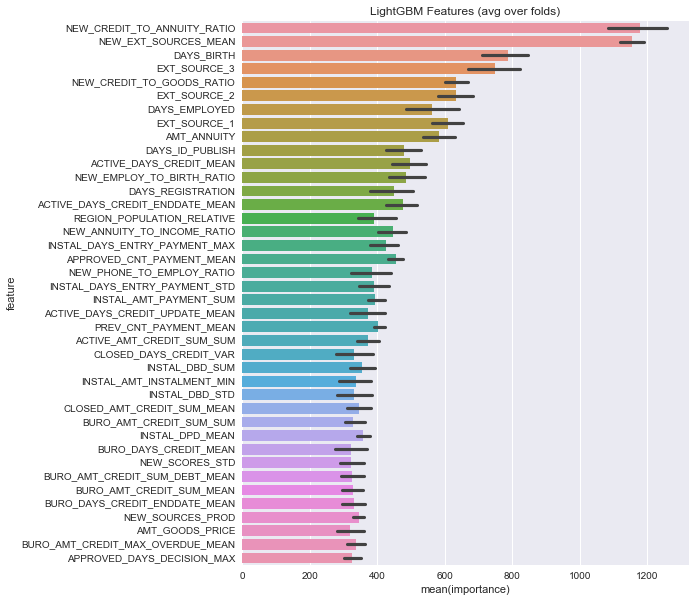

In [10]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.savefig('lgbm_importances01.png')
plt.show()

In [11]:
feature_importance_df.to_csv('feature_importance_df5.csv', index=False)

In [38]:
feature=feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()

In [39]:
feature.shape

(867, 2)

In [55]:
feature[feature['importance']==0].shape

(145, 2)

In [12]:
feature_importance_df1=pd.read_csv('feature_importance_df5.csv')

In [13]:
feature1=feature_importance_df1[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()

In [14]:
feature_importance_df1.head()

,feature,importance,fold
0,AMT_ANNUITY,545,1
1,AMT_CREDIT,272,1
2,AMT_GOODS_PRICE,274,1
3,AMT_INCOME_TOTAL,175,1
4,AMT_REQ_CREDIT_BUREAU_DAY,19,1


In [15]:
df1=feature_importance_df1[feature_importance_df1['fold']==1]

In [16]:
df1['im1'] = np.where(df1['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
df2=feature_importance_df1[feature_importance_df1['fold']==2]

In [18]:
df2['im2'] = np.where(df2['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
df3=feature_importance_df1[feature_importance_df1['fold']==3]

In [20]:
df3['im3'] = np.where(df3['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
df4=feature_importance_df1[feature_importance_df1['fold']==4]

In [22]:
df4['im4'] = np.where(df4['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
df5=feature_importance_df1[feature_importance_df1['fold']==5]

In [24]:
df5['im5'] = np.where(df5['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
# final dataset

In [25]:
from functools import reduce

In [26]:
dfs = [df1, df2, df3, df4,df5]
df_final = reduce(lambda left,right: pd.merge(left,right,on='feature'), dfs)

In [27]:
df_final.head()

,feature,importance_x,fold_x,im1,importance_y,fold_y,im2,importance_x,fold_x,im3,importance_y,fold_y,im4,importance,fold,im5
0,AMT_ANNUITY,545,1,0,648,2,0,637,3,0,502,4,0,578,5,0
1,AMT_CREDIT,272,1,0,368,2,0,358,3,0,273,4,0,302,5,0
2,AMT_GOODS_PRICE,274,1,0,368,2,0,364,3,0,258,4,0,334,5,0
3,AMT_INCOME_TOTAL,175,1,0,226,2,0,191,3,0,146,4,0,184,5,0
4,AMT_REQ_CREDIT_BUREAU_DAY,19,1,0,17,2,0,12,3,0,6,4,0,12,5,0


In [28]:
df_final['sumim']=df_final['im1']+df_final['im2']+df_final['im3']+df_final['im4']+df_final['im5']

In [29]:
df_final[df_final['sumim']>=2].shape

(182, 17)

In [30]:
no_contribute_feature=df_final[df_final['sumim']>=2]['feature']

In [31]:
# drop feature
#df=pd.read_csv('df.csv')
train_df.drop(no_contribute_feature, axis=1, inplace=True)

In [32]:
test_df.drop(no_contribute_feature, axis=1, inplace=True)

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from xgboost import XGBClassifier

/Users/shuozhang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
import xgboost as xgb
from xgboost import plot_importance

In [19]:
train_df=pd.read_csv('train_df_select_feature.csv')

In [ ]:
test_df=pd.read_csv('test_df_select_feature.csv')

In [ ]:
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    # Cross validation model
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
dtest=xgb.DMatrix(test_df[feats])
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = xgb.DMatrix(train_df[feats].iloc[train_idx],train_df['TARGET'].iloc[train_idx])
    dvalid = xgb.DMatrix(train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx])
    valid_y=train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
    params = {'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'booster':'gbtree',
              'nthread' : 4,
              'eta' : 0.05,
              'max_depth' : 6,
              'min_child_weight' : 30,
              'gamma' : 0,
              'subsample' : 0.85,
              'colsample_bytree' : 0.7,
              'colsample_bylevel' : 0.632,
              'alpha' : 0,
              'lambda' : 0,
              'random_state': 99, 
              'silent': True}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
    model=xgb.train(params, dtrain, 2000, watchlist, maximize=True, early_stopping_rounds = 300, verbose_eval=100)
    oof_preds[valid_idx] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    sub_preds += model.predict(dtest,ntree_limit=model.best_ntree_limit) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, dtrain, dvalid, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission7.csv', index= False)

Starting LightGBM. Train shape: (307507, 559), test shape: (48744, 559)
[0]	train-auc:0.723755	valid-auc:0.7226
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 300 rounds.
[100]	train-auc:0.802267	valid-auc:0.774976
[200]	train-auc:0.827911	valid-auc:0.785698
[300]	train-auc:0.84284	valid-auc:0.788938
[400]	train-auc:0.855431	valid-auc:0.790543


In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.savefig('lgbm_importances01.png')
plt.show()

In [ ]:
feature_importance_df.to_csv('feature_importance_df7.csv', index=False)